In [17]:
from mushroom import *

In [18]:
root_folder = "mushrooms"
batch_size = 8

embeds_path = "npy_loads/embeds_all.npy"
gt_labels_path = "npy_loads/ground_truth_labels.npy"
pred_labels_path = "npy_loads/predicted_labels.npy"
species_names_path = "npy_loads/species_names.npy"
image_paths_path = "npy_loads/image_paths.npy"

if all(os.path.exists(p) for p in [embeds_path, gt_labels_path, pred_labels_path, species_names_path, image_paths_path]):
    all_embeds = np.load(embeds_path)
    ground_truth_labels = np.load(gt_labels_path)
    pred_labels = np.load(pred_labels_path)
    species_names = np.load(species_names_path, allow_pickle=True)
    image_paths = np.load(image_paths_path, allow_pickle=True)
    print("All data loaded from saved files.")

All data loaded from saved files.


In [19]:
test_species1 = ['destroying_angel', 'sheathed_woodtuft']
mask = np.isin(ground_truth_labels, test_species1)
subset_embeds1 = all_embeds[mask]
subset_labels1 = ground_truth_labels[mask]

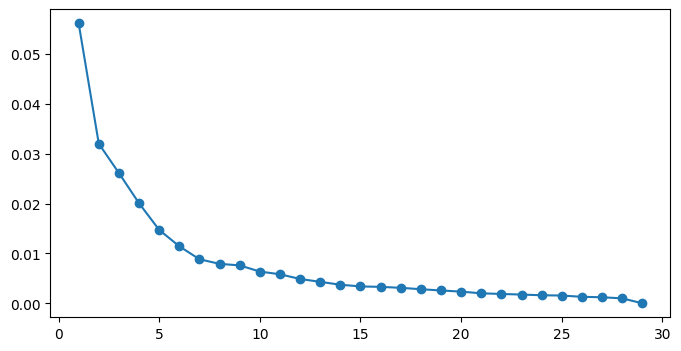

In [20]:
reduced_embeds1, pca_model1 = run_pca(subset_embeds1, n=29)
plot_eigenvalues(pca_model1)

In [21]:
captions_path = "npy_loads/captions.npy"
cleaned_captions_path = "npy_loads/cleaned_captions.npy"
text_embeds_path = "npy_loads/text_embeds.npy"
combined_embeds_path = "npy_loads/combined_embeds.npy"

if os.path.exists(captions_path):
    captions = np.load(captions_path, allow_pickle=True)
    cleaned_captions = np.load(cleaned_captions_path, allow_pickle=True)
    text_embeds = np.load(text_embeds_path)
    combined_embeds = np.load(combined_embeds_path)
    print("All loaded successfully")


All loaded successfully


In [22]:
subset_captions1 = captions[mask]
print(subset_captions1[:3])
print(subset_captions1[-3:])


['a small white mushroom sitting on the ground'
 'a white mushroom sitting on the ground'
 'a close up of a mushroom on the ground']
['a pile of mushrooms sitting on top of a table'
 'a close up of a mushroom on the ground'
 'a bunch of mushrooms sitting on the ground']


In [23]:
sub_image_paths = image_paths[mask]
print(sub_image_paths[:3])

['mushrooms\\destroying_angel\\0.png' 'mushrooms\\destroying_angel\\1.png'
 'mushrooms\\destroying_angel\\10.png']


In [24]:
features_list = classify_mushroom_features_batch(sub_image_paths)

In [25]:
print(features_list[:2])
print(features_list[-2:])
sub_text_embeds = features_to_clip_embeddings(features_list)


[{'cap_shape': 'bell-shaped', 'cap_color': 'white', 'stem_type': 'thin', 'pattern': 'scaly'}, {'cap_shape': 'bell-shaped', 'cap_color': 'white', 'stem_type': 'thin', 'pattern': 'spotted'}]
[{'cap_shape': 'conical', 'cap_color': 'brown', 'stem_type': 'long', 'pattern': 'spotted'}, {'cap_shape': 'bell-shaped', 'cap_color': 'brown', 'stem_type': 'long', 'pattern': 'spotted'}]


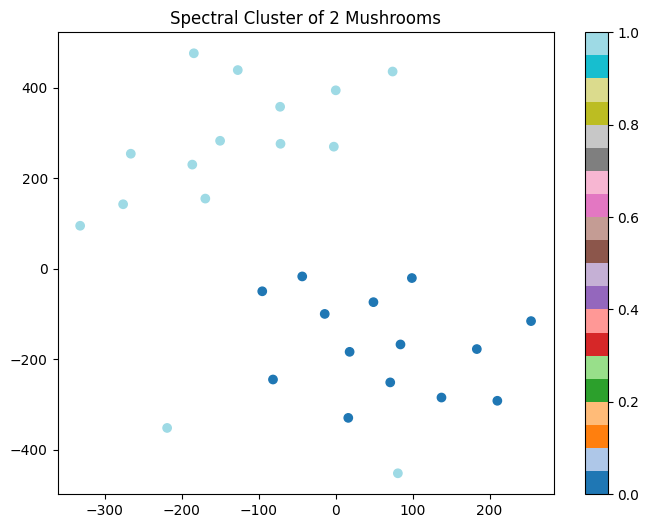

In [26]:
sub_spec_labels1, sub_spec_model1 = cluster_spectral(subset_embeds1, k =2)
pca_embeds = PCA(n_components=20).fit_transform(subset_embeds1)

tsne_embeds = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds)

plot_clusters(tsne_embeds, sub_spec_labels1, title="Spectral Cluster of 2 Mushrooms")

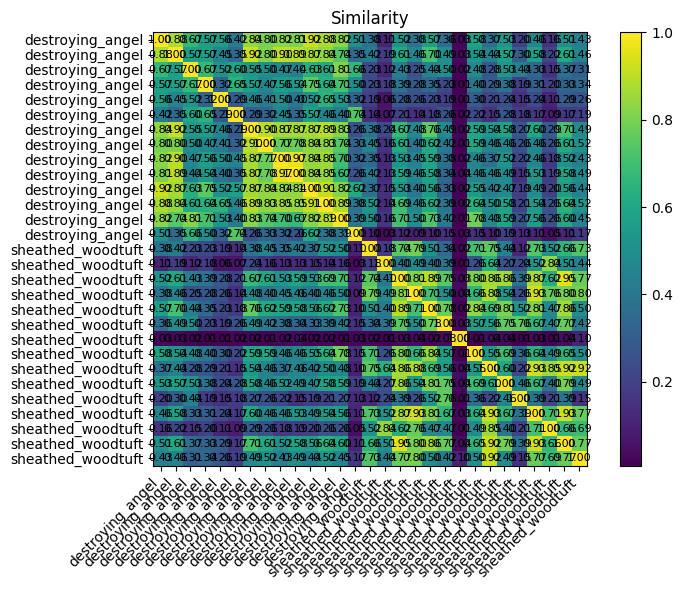

In [27]:
sims = cosine_similarity(subset_embeds1)
row_labels = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths]
col_labels = row_labels  # same for columns if comparing images to themselves

sigma = 0.18
sims_kernel = np.exp(-((1 - sims)**2) / (2 * sigma**2))

plot_similarity_heatmap(sims_kernel, row_labels=row_labels, col_labels=col_labels, title="Similarity")


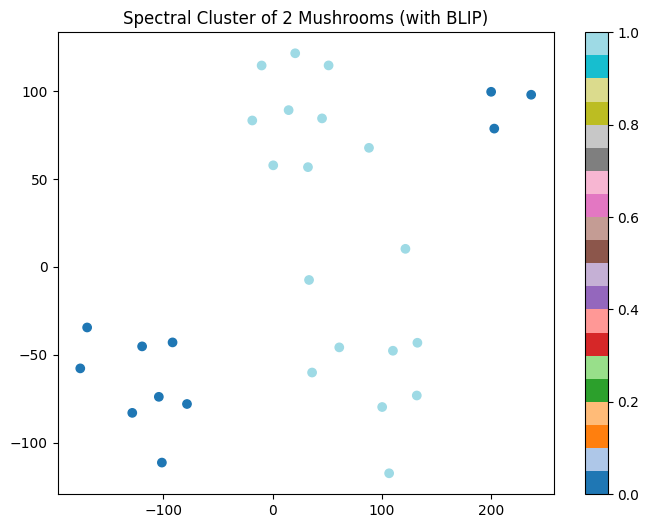

In [28]:
blip_embed = embed_label_prompts(subset_captions1.tolist())
combined_embeds_blip = combine_embeds(subset_embeds1, blip_embed)

sub_spec_labels2, sub_spec_model2 = cluster_spectral(combined_embeds_blip , k =2)
pca_embeds2 = PCA(n_components=20).fit_transform(combined_embeds_blip)

tsne_embeds2 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds2)

plot_clusters(tsne_embeds2, sub_spec_labels2, title="Spectral Cluster of 2 Mushrooms (with BLIP)")

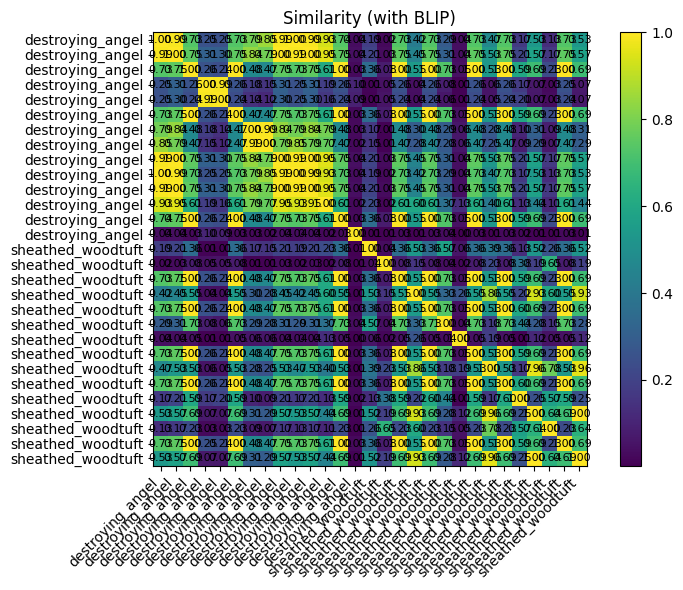

In [29]:
sims2 = cosine_similarity(combined_embeds_blip)
row_labels = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths]
col_labels = row_labels  # same for columns if comparing images to themselves

sigma2 = 0.24
sims_kernel2 = np.exp(-((1 - sims2)**2) / (2 * sigma2**2))

plot_similarity_heatmap(sims_kernel2, row_labels=row_labels, col_labels=col_labels, title="Similarity (with BLIP)")


^Um so that doesn't look too hot. which isn't too crazy from expectations because BLIP by itself doesn't caption in a way that helps cluster by species. Now we can try combine with the feature list. 

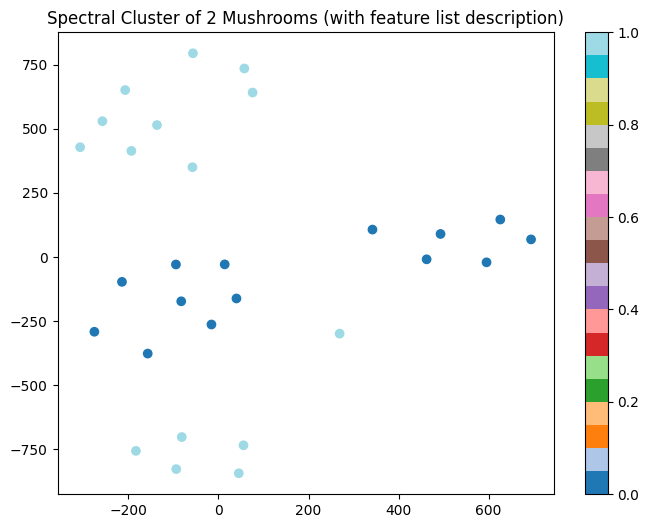

In [30]:
feature_embed = embed_label_prompts(sub_text_embeds)
combined_embeds_ft = combine_embeds(subset_embeds1, feature_embed)

sub_spec_labels3, sub_spec_model3 = cluster_spectral(combined_embeds_ft , k =2)
pca_embeds3 = PCA(n_components=20).fit_transform(combined_embeds_ft)

tsne_embeds3 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds3)

plot_clusters(tsne_embeds3, sub_spec_labels3, title="Spectral Cluster of 2 Mushrooms (with feature list description)")

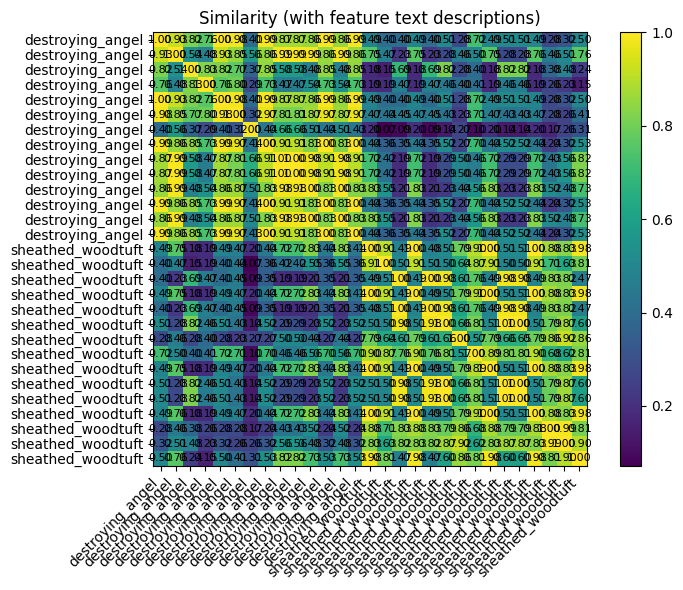

In [31]:
sims3 = cosine_similarity(combined_embeds_ft)
row_labels = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths]
col_labels = row_labels  # same for columns if comparing images to themselves

sigma3 = 0.24
sims_kernel3 = np.exp(-((1 - sims3)**2) / (2 * sigma3**2))

plot_similarity_heatmap(sims_kernel3, row_labels=row_labels, col_labels=col_labels, title="Similarity (with feature text descriptions)")


In [32]:
sil_img = silhouette_score(subset_embeds1, sub_spec_labels1)
print("Silhouette score (image only):", sil_img)
sil_blip = silhouette_score(combined_embeds_blip,sub_spec_labels2)
print("Silhouette score (BLIP+image):", sil_blip)
sil_text = silhouette_score(combined_embeds_ft, sub_spec_labels3)
print("Silhouette score (image+text features):", sil_text)

ari_img = adjusted_rand_score(subset_labels1, sub_spec_labels1)
print("ARI (image only):", ari_img)
ari_blip = adjusted_rand_score(subset_labels1, sub_spec_labels2)
print("ARI (BLIP+image):", ari_blip)
ari_text = adjusted_rand_score(subset_labels1, sub_spec_labels3)
print("ARI (image+text features):", ari_text)


Silhouette score (image only): 0.17990970033174622
Silhouette score (BLIP+image): 0.25040846512719517
Silhouette score (image+text features): 0.3443557117057632
ARI (image only): 1.0
ARI (BLIP+image): 0.6160896130346232
ARI (image+text features): 1.0


Based on the results, it seems that adding BLIP captions introduced noise, but adding structured features could possibly be effective in aiding species clustering. OKAY YAY! clustering with features seemed GOOD -> we can do more tests with this!!!! 

Ok now, we try with two similar mushrooms + some feature embedding. Eg. Field Mushroom and Deathcap. One's dangerous and one's not, but they both have similar features too. 

In [33]:
test_species2 = ['field_mushroom', 'deathcap']
mask2 = np.isin(ground_truth_labels, test_species2)
subset_embeds2 = all_embeds[mask2]
subset_labels2 = ground_truth_labels[mask2]

In [34]:
sub_image_paths2 = image_paths[mask2]
features_list2 = classify_mushroom_features_batch(sub_image_paths2)
sub_text_embeds2 = features_to_clip_embeddings(features_list2)
print(features_list2[:2])
print(features_list2[-2:])

[{'cap_shape': 'bell-shaped', 'cap_color': 'brown', 'stem_type': 'thick', 'pattern': 'scaly'}, {'cap_shape': 'bell-shaped', 'cap_color': 'white', 'stem_type': 'long', 'pattern': 'spotted'}]
[{'cap_shape': 'umbrella', 'cap_color': 'brown', 'stem_type': 'thick', 'pattern': 'scaly'}, {'cap_shape': 'bell-shaped', 'cap_color': 'white', 'stem_type': 'thick', 'pattern': 'spotted'}]


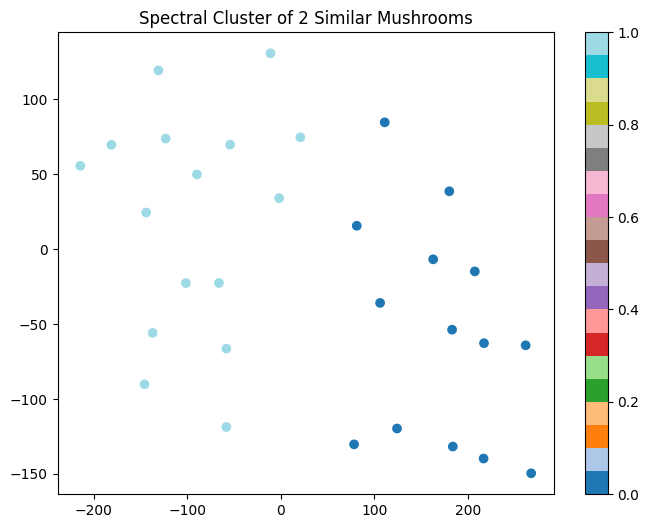

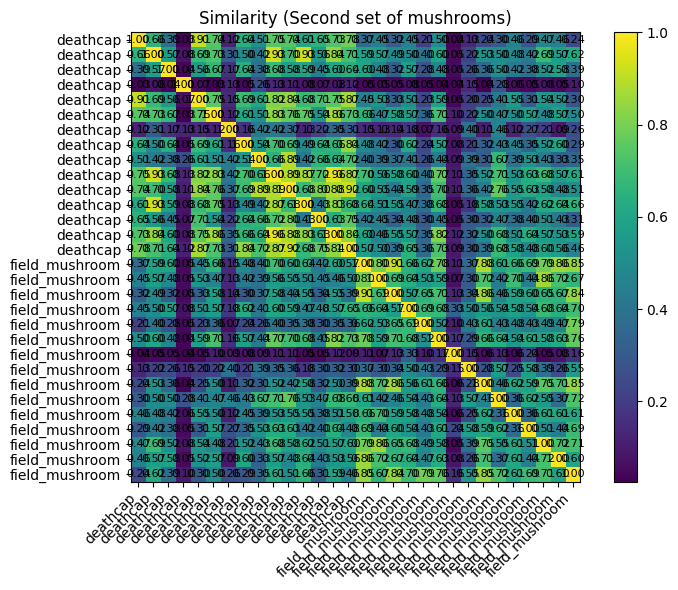

In [40]:
sub_spec_labels4, sub_spec_model4 = cluster_spectral(subset_embeds2, k =2)
pca_embeds4 = PCA(n_components=20).fit_transform(subset_embeds2)

tsne_embeds4 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds4)

plot_clusters(tsne_embeds4, sub_spec_labels4, title="Spectral Cluster of 2 Similar Mushrooms")

sims4 = cosine_similarity(subset_embeds2)
row_labels4 = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths2]
col_labels4 = row_labels4  

sigma4 = 0.13
sims_kernel4 = np.exp(-((1 - sims4)**2) / (2 * sigma4**2))

plot_similarity_heatmap(sims_kernel4, row_labels=row_labels4, col_labels=col_labels4, title="Similarity (Second set of mushrooms)")



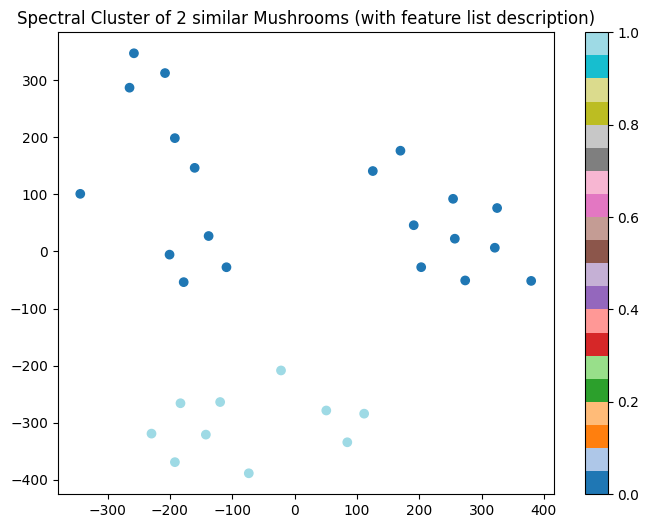

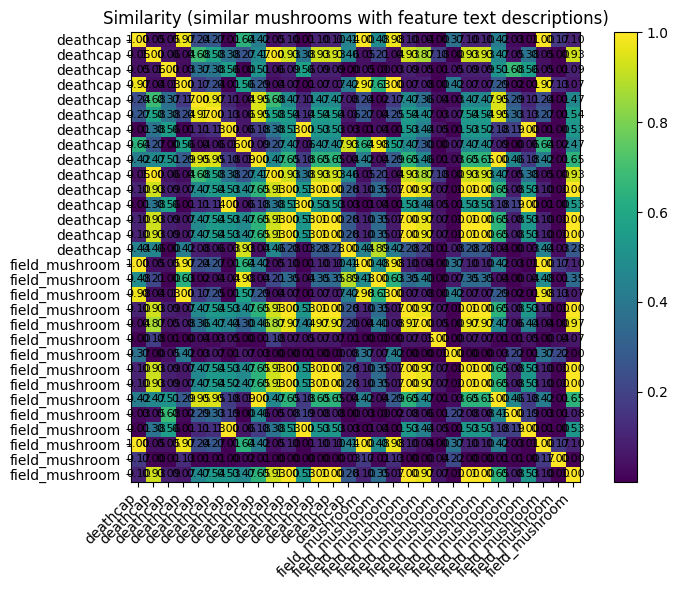

In [42]:
feature_embed2 = embed_label_prompts(sub_text_embeds2)
combined_embeds_ft2 = combine_embeds(subset_embeds2, feature_embed2)

sub_spec_labels5, sub_spec_model5 = cluster_spectral(combined_embeds_ft2 , k =2)
pca_embeds5 = PCA(n_components=20).fit_transform(combined_embeds_ft2)

tsne_embeds5 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds5)

plot_clusters(tsne_embeds5, sub_spec_labels5, title="Spectral Cluster of 2 similar Mushrooms (with feature list description)")

sims5 = cosine_similarity(combined_embeds_ft2)
row_labels5 = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths2]
col_labels5 = row_labels5  # same for columns if comparing images to themselves

sigma5 = 0.12
sims_kernel5 = np.exp(-((1 - sims5)**2) / (2 * sigma5**2))

plot_similarity_heatmap(sims_kernel5, row_labels=row_labels5, col_labels=col_labels5, title="Similarity (similar mushrooms with feature text descriptions)")



In [43]:
sil_img2 = silhouette_score(subset_embeds2, sub_spec_labels4)
print("Silhouette score (image only):", sil_img2)
sil_text2 = silhouette_score(combined_embeds_ft2, sub_spec_labels5)
print("Silhouette score (image+text features):", sil_text2)

ari_img2 = adjusted_rand_score(subset_labels2, sub_spec_labels4)
print("ARI (image only):", ari_img2)
ari_text2 = adjusted_rand_score(subset_labels2, sub_spec_labels5)
print("ARI (image+text features):", ari_text2)

Silhouette score (image only): 0.11414231088456764
Silhouette score (image+text features): 0.37654584709090544
ARI (image only): 0.8665291223615299
ARI (image+text features): -0.013280632411067193


Ok so that was like rly bad...